In [1]:
# ADVANCED HYBRID ENSEMBLE FOR FINANCIAL FRAUD DETECTION

In [2]:
pip install numpy pandas matplotlib seaborn shap

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install imbalanced-learn xgboost lightgbm catboost

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import warnings
warnings.filterwarnings('ignore')

In [5]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (classification_report, confusion_matrix,
                             roc_auc_score, precision_recall_curve, auc)
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.neighbors import LocalOutlierFactor
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

In [6]:
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import StackingClassifier

In [7]:
# 1. LOAD DATA
df = pd.read_csv(r"C:\Users\hp\Downloads\creditcard (2).csv")
print(df.shape)
print(df['Class'].value_counts())

(284807, 31)
Class
0    284315
1       492
Name: count, dtype: int64


In [8]:
df.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [9]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [11]:
# 2. PREPROCESSING
scaler = StandardScaler()
df['Amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1, 1))

In [12]:
X = df.drop('Class', axis=1)
y = df['Class']

In [13]:
# Balance classes
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)
print('After SMOTE:', y_res.value_counts())

After SMOTE: Class
0    284315
1    284315
Name: count, dtype: int64


In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res, test_size=0.2, random_state=42, stratify=y_res
)

In [15]:
# 3. UNSUPERVISED MODELS (ANOMALY SCORES)

In [16]:
iso = IsolationForest(contamination=0.02, random_state=42)
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.02)

In [17]:
iso.fit(X_train)
iso_scores = -iso.decision_function(X_train)
lof_scores = -lof.fit_predict(X_train)

In [18]:
# Add unsupervised anomaly scores as new features
X_train['iso_score'] = iso_scores
X_train['lof_score'] = np.abs(lof_scores)
X_test['iso_score'] = -iso.decision_function(X_test)
X_test['lof_score'] = np.abs(lof.fit_predict(X_test))

In [19]:
# 4. SUPERVISED ENSEMBLE BASE MODELS

In [20]:
xgb = XGBClassifier(n_estimators=300, learning_rate=0.05, max_depth=5,
                    subsample=0.8, colsample_bytree=0.8, random_state=42)
lgbm = LGBMClassifier(n_estimators=300, learning_rate=0.05,
                      num_leaves=31, random_state=42)
cat = CatBoostClassifier(verbose=0, depth=6, learning_rate=0.05, iterations=300)

In [21]:
# 5. STACKING ENSEMBLE (META MODEL)

In [22]:
meta = LogisticRegression(max_iter=1000)
stack_model = StackingClassifier(
    estimators=[('xgb', xgb), ('lgbm', lgbm), ('cat', cat)],
    final_estimator=meta,
    cv=5,
    stack_method='predict_proba'
)

In [23]:
# Train
stack_model.fit(X_train, y_train)
y_pred = stack_model.predict(X_test)
y_prob = stack_model.predict_proba(X_test)[:, 1]

[LightGBM] [Info] Number of positive: 227452, number of negative: 227452
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.078959 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 454904, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 181962, number of negative: 181961
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060910 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 363923, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500001 -> initscore=0.000005
[LightGBM] [Info] Start training from score 0.000005
[LightGBM] [Info] Number of positive: 181962, number of negativ

In [24]:
# 6. EVALUATION

In [25]:
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))


Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       1.00      1.00      1.00     56863

    accuracy                           1.00    113726
   macro avg       1.00      1.00      1.00    113726
weighted avg       1.00      1.00      1.00    113726

ROC-AUC: 0.9999806887532784


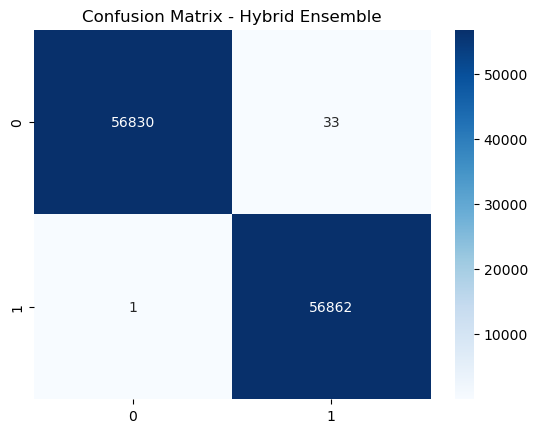

In [26]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Hybrid Ensemble")
plt.show()

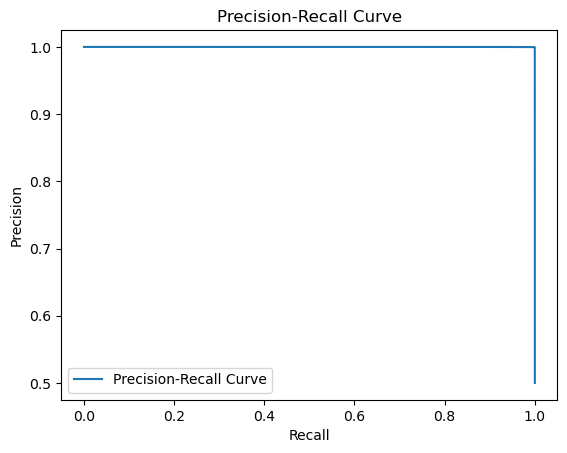

In [27]:
precision, recall, _ = precision_recall_curve(y_test, y_prob)
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

In [28]:
# 7. FEATURE IMPORTANCE (EXPLAINABILITY)

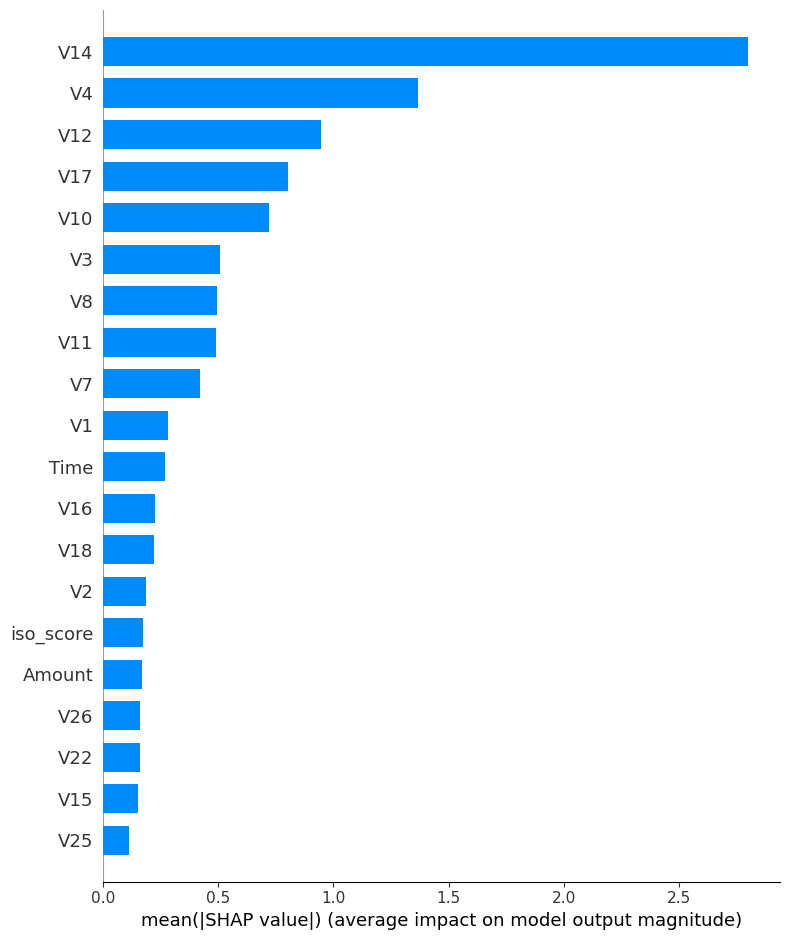

In [29]:
explainer = shap.Explainer(stack_model.named_estimators_['xgb'])
shap_values = explainer(X_test.sample(1000, random_state=42))
shap.summary_plot(shap_values, X_test.sample(1000, random_state=42), plot_type="bar")

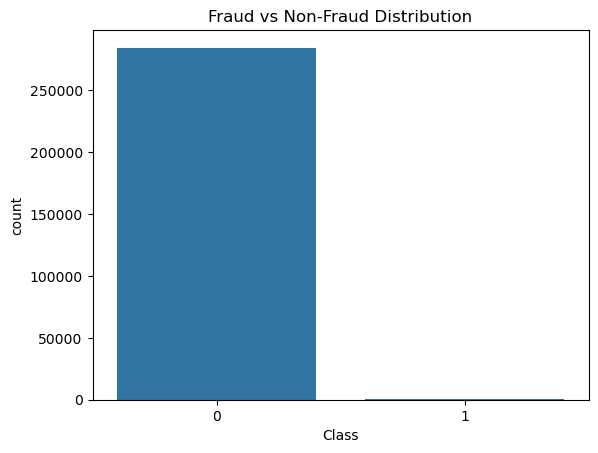

In [41]:
# CLASS DISTRIBUTION  GRAPH
sns.countplot(x='Class', data=df)
plt.title("Fraud vs Non-Fraud Distribution")
plt.show()

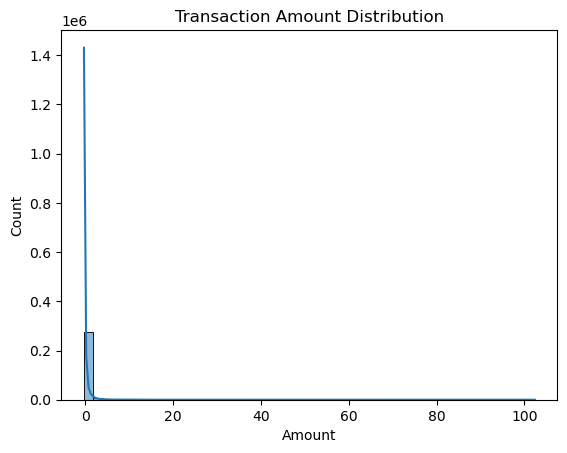

In [43]:
# AMOUNT DISTRIBUTION GRAPH
sns.histplot(df['Amount'], bins=50, kde=True)
plt.title("Transaction Amount Distribution")
plt.show()


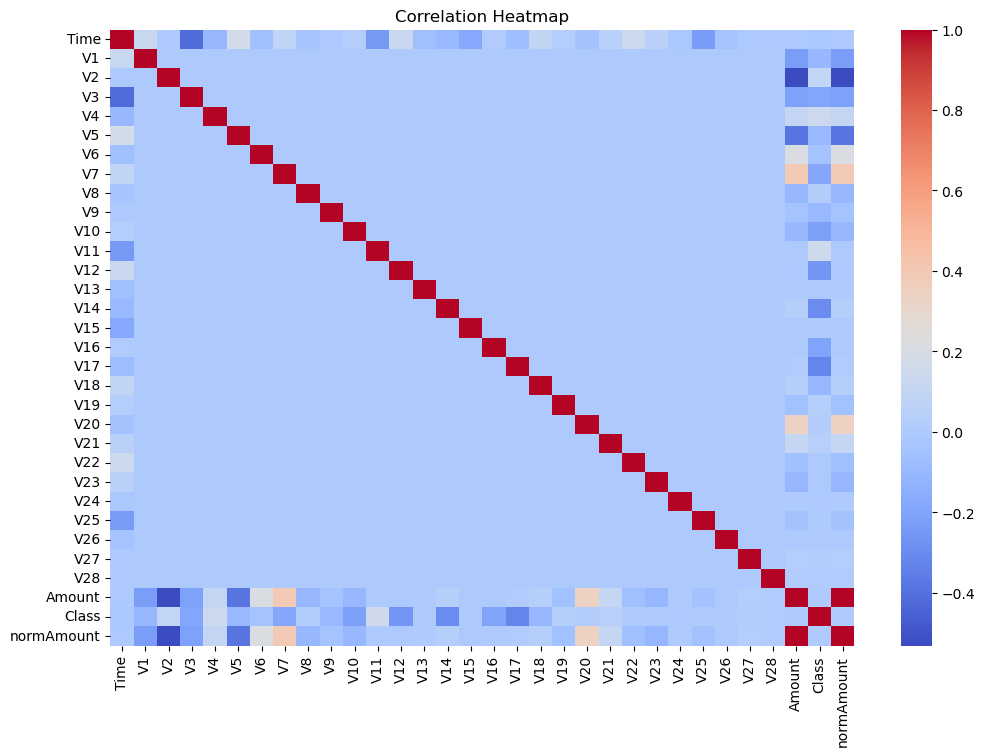

In [44]:
#CORRELATION HEATMAP
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(), cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()


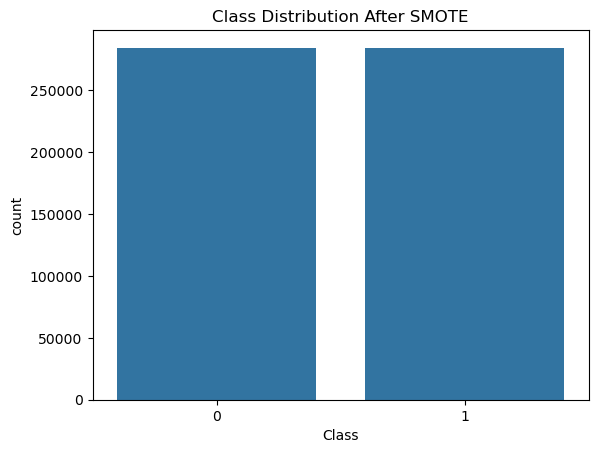

In [42]:
#SMOTE RESULT GRAPH
sns.countplot(x=y_res)
plt.title("Class Distribution After SMOTE")
plt.show()